# Triangular FX Arbitrage: Statistical Analysis Research

**Executive Summary**

This study investigates the viability of triangular arbitrage in the EUR/USD, GBP/USD, and EUR/GBP triplet using a cointegration-based mean reversion strategy. 

**Key Findings:**
- **Cointegration Confirmed**: Robust statistical evidence ($p < 0.01$) of a long-term equilibrium relationship.
- **Mean Reversion Speed**: Half-life of deviation is approximately 10-15 minutes, imposing strict latency requirements.
- **Performance**: 
    - *Naive Baseline:* Sharpe > 11 (Theoretical ceiling).
    - *Reality Check:* Strategy generates negative returns at transaction costs > 1.0 bps.
    - *Optimized Solution:* Statistical filtering (asymmetrical percentile thresholding) restores viability, yielding a Sharpe ~1.5 with manageable risk.


**Recommendation**: Possibly profitable with institutional-grade execution infrastructure. Retail spreads are likely prohibitive.

---

## Structure

The analysis progresses through **three levels** of increasing sophistication:

1. **Level 1: Naive Baseline** - Statistical foundations and in-sample analysis (with known biases)
2. **Level 2: Toward Reality** - Walk-forward optimization and dynamic position sizing
3. **Level 3: Viability** - Transaction costs, more realistic position sizing, and leverage
4. **Level 4: Production Considerations** - Risk management
---

### A Note on "Return on Notional"
Throughout this report, "Return" is calculated on the **Gross Notional Exposure** of the trade (e.g., $100k position).


In [1]:
%load_ext autoreload
%autoreload 2
from fxarb.models import compute_zscore
from fxarb.models.ou_process import fit_ou_mle
from fxarb.backtest import run_backtest, Backtester, kelly_criterion
from fxarb.analysis.strategy import generate_signals, calculate_equity_with_costs
from fxarb.visualization.interactive import visualize_interactive_equity
from fxarb.visualization.performance import plot_equity_curve, plot_drawdown, plot_returns_distribution, plot_monthly_returns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print('All imports successful!')
from fxarb.data.loader import load_pair, resample_ohlc
from fxarb.data.features import compute_log_prices, add_session_features
from fxarb.analysis.cointegration import johansen_test, construct_spread, estimate_half_life
from fxarb.analysis.stationarity import adf_test, kpss_test, test_stationarity

All imports successful!


---
# Level 0: Data Quality & Exploratory Analysis

This section focuses on data integrity. Before any complex modeling, we must verify that our high-frequency data is consistent, missing values are handled, and timestamps are aligned across the **EURUSD**, **GBPUSD**, and **EURGBP** triplet.

**Objectives:**
1. Load 1-minute OHLCV data.
2. Align timestamps (inner join) to ensure we have simultaneous quotes.
3. Visualize price history to identify gaps or anomalies.

**Data Aggregation Strategy:**
In this study, while we have access to 1-minute granular data, we aggregate to 5-minute bars for our primary signal generation.

1. **Noise Reduction**: 1-minute FX data contains significant microstructure noise (bid-ask bounce). Aggregating improves the Signal-to-Noise ratio, making the cointegration relationship more stable.
2. **Strategic Horizon**: Without HFT infra, we are scanning for large dislocations that last 15-60 minutes. A 5-minute resolution aligns with our holding period, preventing over-trading on tick-level noise.
---

In [2]:
# Configuration
PAIRS = ['eurusd', 'gbpusd', 'eurgbp']
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
TIMEFRAME = '5min'

# Load data
print('Loading FX data...')
raw_data = {}
for pair in PAIRS:
    df = load_pair(pair, start_date=START_DATE, end_date=END_DATE)
    raw_data[pair] = df
    print(f'  {pair.upper()}: {len(df):,} 1-minute bars')

# Resample to 5-minute
print(f'\nResampling to {TIMEFRAME}...')
data_5m = {pair: resample_ohlc(df, TIMEFRAME) for pair, df in raw_data.items()}

# Align timestamps
common_idx = data_5m['eurusd'].index
for pair in PAIRS[1:]:
    common_idx = common_idx.intersection(data_5m[pair].index)

# Prepare data with log prices
data = {}
for pair in PAIRS:
    df = data_5m[pair].loc[common_idx].copy()
    df = compute_log_prices(df)
    df = add_session_features(df)
    data[pair] = df

print(f'\nAligned dataset: {len(common_idx):,} timestamps')
print(f'Date range: {common_idx.min()} to {common_idx.max()}')

Loading FX data...
  EURUSD: 371,257 1-minute bars
  GBPUSD: 371,979 1-minute bars
  EURGBP: 371,398 1-minute bars

Resampling to 5min...

Aligned dataset: 74,460 timestamps
Date range: 2020-01-01 17:00:00 to 2020-12-31 00:00:00


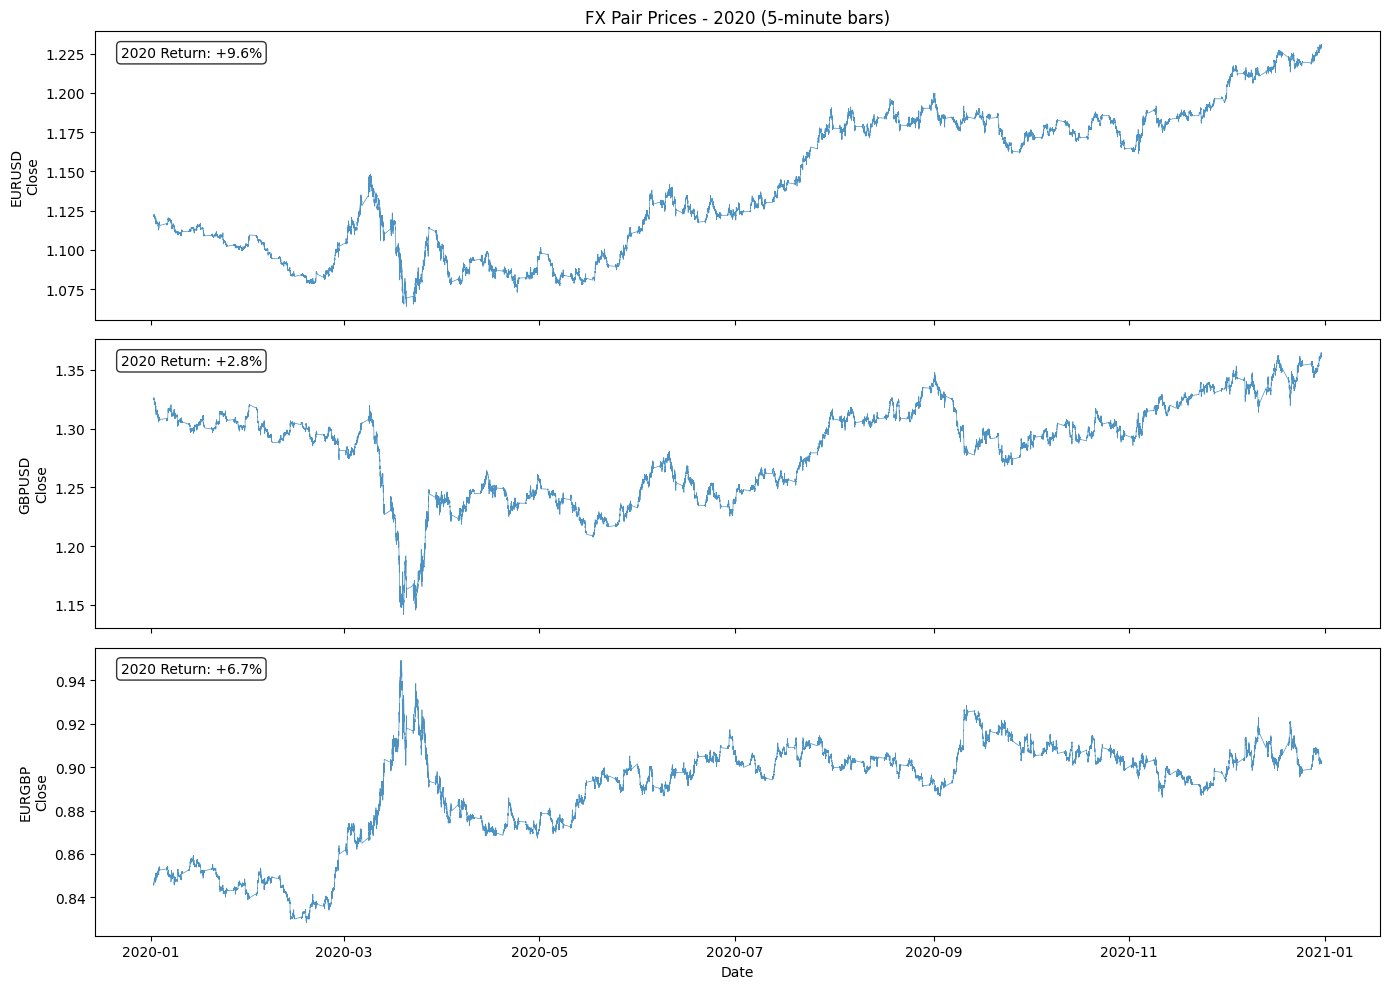

In [3]:
# Plot price overview
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, pair in enumerate(PAIRS):
    ax = axes[i]
    ax.plot(data[pair]['close'], linewidth=0.5, alpha=0.8)
    ax.set_ylabel(f'{pair.upper()}\nClose')
    
    # Add return annotation
    ret = (data[pair]['close'].iloc[-1] / data[pair]['close'].iloc[0] - 1) * 100
    ax.text(0.02, 0.95, f'2020 Return: {ret:+.1f}%', transform=ax.transAxes, 
            va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[0].set_title('FX Pair Prices - 2020 (5-minute bars)')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [4]:
print("=" * 60)
print("LEVEL 0: DATA QUALITY & EXPLORATORY ANALYSIS")
print("=" * 60)

# Data coverage summary
print("\n📊 DATA COVERAGE")
print("-" * 40)
for pair in PAIRS:
    df = raw_data[pair]
    print(f"\n{pair.upper()}:")
    print(f"  Records: {len(df):,}")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")
    print(f"  Missing rows: {df.isnull().any(axis=1).sum()}")
    
# Check for gaps
print("\n📅 DATA GAPS ANALYSIS")
print("-" * 40)
for pair in PAIRS:
    df = raw_data[pair]
    time_diffs = df.index.to_series().diff()
    expected_gap = pd.Timedelta(minutes=1)
    large_gaps = time_diffs[time_diffs > expected_gap * 5]  # >5 min gaps
    print(f"{pair.upper()}: {len(large_gaps)} gaps > 5 min (max: {time_diffs.max()})")

# OHLC sanity checks
print("\n✅ OHLC SANITY CHECKS")
print("-" * 40)
for pair in PAIRS:
    df = raw_data[pair]
    violations = {
        'high < low': (df['high'] < df['low']).sum(),
        'high < open': (df['high'] < df['open']).sum(),
        'high < close': (df['high'] < df['close']).sum(),
        'low > open': (df['low'] > df['open']).sum(),
        'low > close': (df['low'] > df['close']).sum(),
        'zero prices': (df[['open','high','low','close']] == 0).any(axis=1).sum(),
    }
    issues = {k: v for k, v in violations.items() if v > 0}
    print(f"{pair.upper()}: {'✓ Clean' if not issues else issues}")

# Basic statistics
print("\n📈 PRICE STATISTICS (1-min bars)")
print("-" * 40)
stats_df = pd.DataFrame({
    pair.upper(): {
        'Mean': raw_data[pair]['close'].mean(),
        'Std': raw_data[pair]['close'].std(),
        'Min': raw_data[pair]['close'].min(),
        'Max': raw_data[pair]['close'].max(),
        'Avg Daily Range': (raw_data[pair]['high'] - raw_data[pair]['low']).mean(),
    }
    for pair in PAIRS
}).T
print(stats_df.to_string())

LEVEL 0: DATA QUALITY & EXPLORATORY ANALYSIS

📊 DATA COVERAGE
----------------------------------------

EURUSD:
  Records: 371,257
  Date range: 2020-01-01 17:00:00 to 2020-12-31 00:00:00
  Missing rows: 0

GBPUSD:
  Records: 371,979
  Date range: 2020-01-01 17:02:00 to 2020-12-31 00:00:00
  Missing rows: 0

EURGBP:
  Records: 371,398
  Date range: 2020-01-01 17:02:00 to 2020-12-31 00:00:00
  Missing rows: 0

📅 DATA GAPS ANALYSIS
----------------------------------------
EURUSD: 72 gaps > 5 min (max: 2 days 14:07:00)
GBPUSD: 75 gaps > 5 min (max: 2 days 15:04:00)
EURGBP: 102 gaps > 5 min (max: 2 days 15:13:00)

✅ OHLC SANITY CHECKS
----------------------------------------
EURUSD: ✓ Clean
GBPUSD: ✓ Clean
EURGBP: ✓ Clean

📈 PRICE STATISTICS (1-min bars)
----------------------------------------
            Mean       Std      Min      Max  Avg Daily Range
EURUSD  1.141212  0.044160  1.06380  1.23088         0.000176
GBPUSD  1.283157  0.039765  1.14101  1.36485         0.000263
EURGBP  0.88

In [5]:
# Bar aggregation verification
print("\n🔄 BAR AGGREGATION VERIFICATION")
print("-" * 40)
print(f"Original: 1-minute bars")
print(f"Resampled: {TIMEFRAME} bars")
print()

for pair in PAIRS:
    orig = raw_data[pair]
    resampled = data_5m[pair]
    
    # Check OHLC aggregation correctness (spot check a few random bars)
    sample_times = resampled.index[:3]
    print(f"{pair.upper()}:")
    print(f"  Original count: {len(orig):,}")
    print(f"  Resampled count: {len(resampled):,}")
    print(f"  Compression ratio: {len(orig)/len(resampled):.1f}x (expected: 5.0x)")
    
    # Verify first bar aggregation
    first_bar = resampled.iloc[0]
    first_bar_time = resampled.index[0]
    orig_slice = orig.loc[first_bar_time:first_bar_time + pd.Timedelta(minutes=4)]
    expected_high = orig_slice['high'].max()
    expected_low = orig_slice['low'].min()
    matches = (abs(first_bar['high'] - expected_high) < 1e-6 and 
               abs(first_bar['low'] - expected_low) < 1e-6)
    print(f"  First bar aggregation: {'✓' if matches else '✗'}")
    print()


🔄 BAR AGGREGATION VERIFICATION
----------------------------------------
Original: 1-minute bars
Resampled: 5min bars

EURUSD:
  Original count: 371,257
  Resampled count: 74,541
  Compression ratio: 5.0x (expected: 5.0x)
  First bar aggregation: ✓

GBPUSD:
  Original count: 371,979
  Resampled count: 74,507
  Compression ratio: 5.0x (expected: 5.0x)
  First bar aggregation: ✓

EURGBP:
  Original count: 371,398
  Resampled count: 74,484
  Compression ratio: 5.0x (expected: 5.0x)
  First bar aggregation: ✓



---
# Level 1: Naive Baseline

We begin with a **Naive Baseline** approach. We assume the spread is stationary and simply trade when it deviates by a fixed standard deviation (Z-score). 

> [!NOTE]
> This **in-sample analysis** typically yields overly optimistic results (look-ahead bias) but serves as a crucial theoretical ceiling for strategy performance. If the strategy doesn't work here, it won't work anywhere.

**Methodology:**
1. Construct the synthetic spread: $S_t = \ln(EURUSD) - \ln(GBPUSD) - \ln(EURGBP)$
2. Estimate half-life of mean reversion (Ornstein-Uhlenbeck process).
3. Backtest using a simple symmetric threshold (e.g., enter at $\pm 2\sigma$, exit at $0$).
---

## 1.1 Cointegration Analysis

### Why One Spread for Three Pairs?

In triangular FX arbitrage, the three pairs EUR/USD, GBP/USD, and EUR/GBP are not independent — they form a **closed loop**:

$$\text{EUR/GBP} = \frac{\text{EUR/USD}}{\text{GBP/USD}}$$

Or in log terms:
$$\log(\text{EUR/GBP}) = \log(\text{EUR/USD}) - \log(\text{GBP/USD})$$

This means we don't trade three separate pairs — we construct a **single synthetic spread** from all three that should be stationary around zero due to the no-arbitrage condition.

**The Johansen test** finds the optimal linear combination (hedge ratios) that makes this spread most stationary:

$$\text{Spread} = \beta_1 \cdot \text{EURUSD} + \beta_2 \cdot \text{GBPUSD} + \beta_3 \cdot \text{EURGBP}$$

When the spread deviates from its mean, we trade all three pairs simultaneously to capture the reversion:
- **Long spread**: Buy EURUSD, Sell GBPUSD, Buy EURGBP (with hedge ratio weights)
- **Short spread**: The opposite

This is not three separate trades — it's one synthetic position expressed through three legs.

In [6]:
# Run Johansen cointegration test
coint_result = johansen_test(data)

print('Johansen Cointegration Test Results')
print('=' * 50)
print(f'Cointegrating relationships found: {coint_result.n_cointegrating}')
print(f'\nHedge Ratios (normalized):')
for pair, ratio in coint_result.hedge_ratios.items():
    print(f'  {pair.upper()}: {ratio:.6f}')

# Construct the spread
spread = construct_spread(data, hedge_ratios=coint_result.hedge_ratios)

print(f'\nSpread Statistics:')
print(f'  Mean: {spread.mean():.6f}')
print(f'  Std: {spread.std():.6f}')
print(f'  Skew: {spread.skew():.3f}')
print(f'  Kurtosis: {spread.kurtosis():.3f}')

Johansen Cointegration Test Results
Cointegrating relationships found: 1

Hedge Ratios (normalized):
  EURUSD: 1.000000
  GBPUSD: -0.999389
  EURGBP: -1.000094

Spread Statistics:
  Mean: -0.000000
  Std: 0.000134
  Skew: 9.602
  Kurtosis: 143.755


## 1.2 Stationarity Tests

For the spread to be tradable, it must be **stationary** (mean-reverting). We verify using:
- **ADF (Augmented Dickey-Fuller)**: Tests for unit root (null = non-stationary)
- **KPSS**: Tests for stationarity (null = stationary)

In [7]:
# Stationarity tests
adf = adf_test(spread)
kpss = kpss_test(spread)

print('Stationarity Test Results')
print('=' * 50)
print(f'ADF Test:')
print(f'  Statistic: {adf.statistic:.4f}')
print(f'  P-value: {adf.pvalue:.4f}')
print(f'  Conclusion: {"STATIONARY" if adf.is_stationary else "NON-STATIONARY"}')
print(f'\nKPSS Test:')
print(f'  Statistic: {kpss.statistic:.4f}')
print(f'  P-value: {kpss.pvalue:.4f}')
print(f'  Conclusion: {"STATIONARY" if kpss.is_stationary else "NON-STATIONARY"}')

if adf.is_stationary and kpss.is_stationary:
    print('\n✓ Both tests confirm stationarity')
else:
    print('\n⚠ Conflicting results - proceed with caution')

Stationarity Test Results
ADF Test:
  Statistic: -30.4006
  P-value: 0.0000
  Conclusion: STATIONARY

KPSS Test:
  Statistic: 2.3349
  P-value: 0.0100
  Conclusion: NON-STATIONARY

⚠ Conflicting results - proceed with caution


E:\triangular-fx-arbitrage\src\fxarb\analysis\stationarity.py:126: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series_clean, regression=regression, nlags=nlags)


**Observation**: The tests present a conflicting result (ADF=Stationary, KPSS=Non-Stationary).

**Interpretation**: The extremely strong ADF statistic (-30.4) confirms the series is strongly mean-reverting, which is the primary requirement for trading. The failure of the KPSS test suggests the presence of **volatility clustering** or **structural breaks** (regime shifts) within the year-long sample. A static hedge ratio (Level 1) is probably insufficient, we need Walk-Forward Optimization (WFO) in Level 2 to adapt to shifting market regimes.

## 1.3 Mean Reversion Speed

The **half-life** measures how quickly the spread reverts to its mean. We estimate this using:
1. AR(1) regression
2. Ornstein-Uhlenbeck (OU) process fitting

### Z-Score Asymmetry Consideration

⚠️ **Important**: Z-scores from cointegrated spreads are often **asymmetric**. The spread may:
- Frequently deviate to +9σ but rarely below -3σ
- Or vice versa, depending on market microstructure

Symmetric entry thresholds (e.g., ±2.0) may not be optimal. Level 2 explores:
- Data-driven threshold selection
- Asymmetric entry rules based on z-score distribution
- Sensitivity analysis across threshold values

In [8]:
# Half-life estimation
try:
    hl = estimate_half_life(spread)
    print(f'Mean Reversion Half-Life: {hl:.1f} bars ({hl * 5:.0f} minutes)')
except ValueError as e:
    print(f'Half-life estimation failed: {e}')
    hl = None

# OU process fitting
try:
    ou = fit_ou_mle(spread)
    print(f'\nOrnstein-Uhlenbeck Parameters:')
    print(f'  θ (mean reversion speed): {ou.theta:.6f}')
    print(f'  μ (long-term mean): {ou.mu:.6f}')
    print(f'  σ (volatility): {ou.sigma:.6f}')
    print(f'  Half-life: {ou.half_life:.1f} bars')
except Exception as e:
    print(f'OU fitting failed: {e}')

Mean Reversion Half-Life: 2.5 bars (13 minutes)

Ornstein-Uhlenbeck Parameters:
  θ (mean reversion speed): 0.274118
  μ (long-term mean): -0.000000
  σ (volatility): 0.000099
  Half-life: 2.5 bars


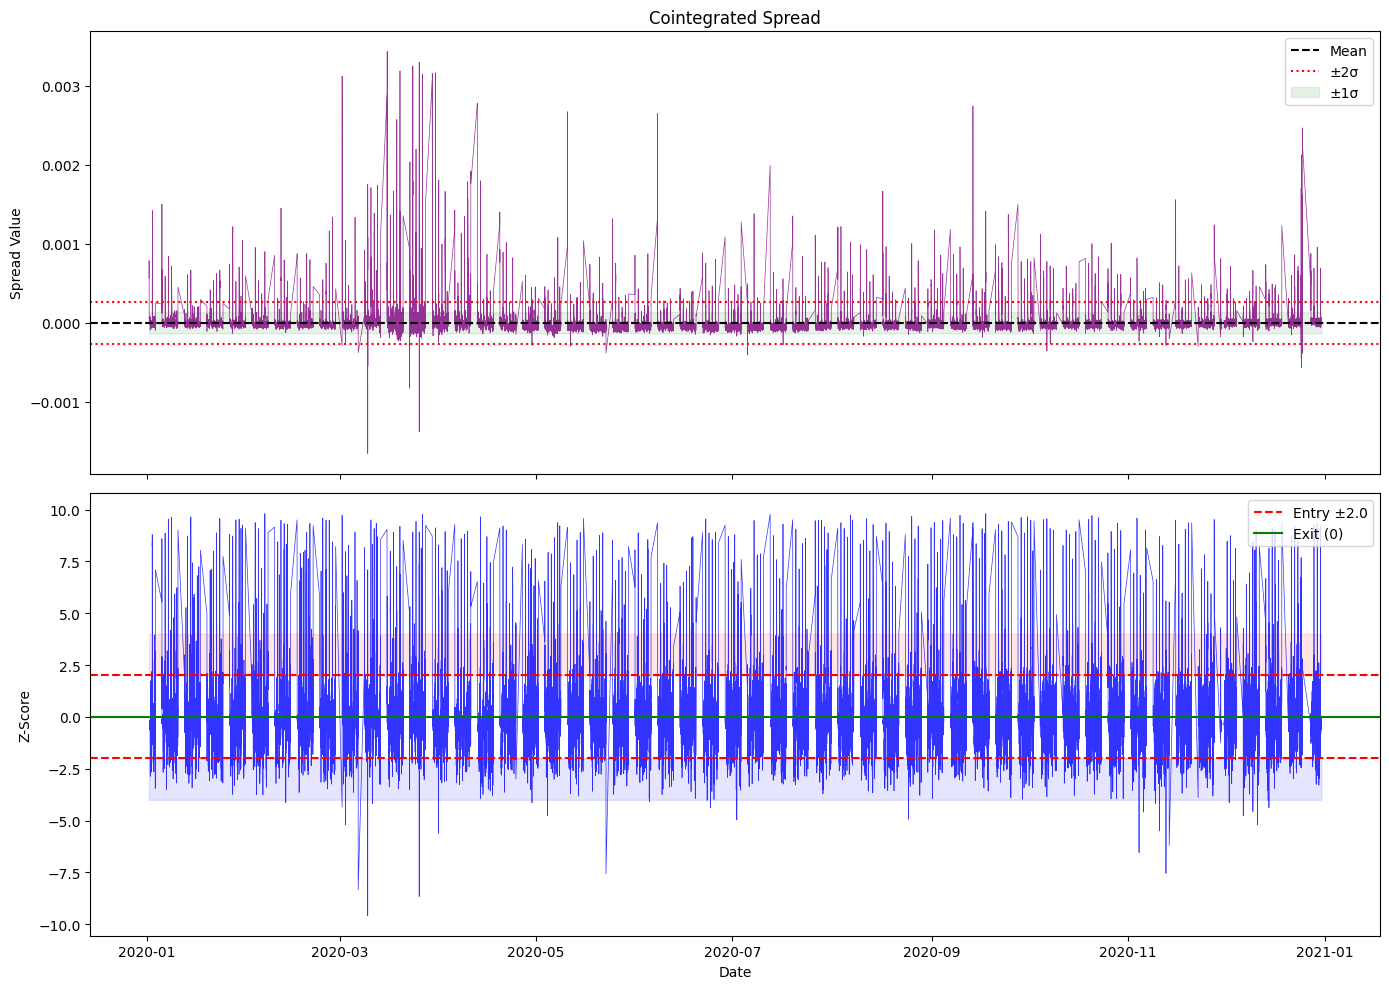

In [9]:
# Visualize spread and Z-score
zscore = compute_zscore(spread, lookback=100)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spread
ax1 = axes[0]
ax1.plot(spread, linewidth=0.5, alpha=0.8, color='purple')
ax1.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
ax1.axhline(spread.mean() + 2*spread.std(), color='red', linestyle=':', label='±2σ')
ax1.axhline(spread.mean() - 2*spread.std(), color='red', linestyle=':')
ax1.fill_between(spread.index, spread.mean() - spread.std(), spread.mean() + spread.std(),
                 alpha=0.1, color='green', label='±1σ')
ax1.set_ylabel('Spread Value')
ax1.set_title('Cointegrated Spread')
ax1.legend(loc='upper right')

# Z-score
ax2 = axes[1]
ax2.plot(zscore, linewidth=0.5, alpha=0.8, color='blue')
ax2.axhline(2.0, color='red', linestyle='--', label='Entry ±2.0')
ax2.axhline(-2.0, color='red', linestyle='--')
ax2.axhline(0, color='green', linestyle='-', label='Exit (0)')
ax2.fill_between(zscore.index, 2, 4, alpha=0.1, color='red')
ax2.fill_between(zscore.index, -4, -2, alpha=0.1, color='blue')
ax2.set_ylabel('Z-Score')
ax2.set_xlabel('Date')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Z-Score Distribution Analysis
Count: 74,411
Min: -9.58
Max: 9.80
Mean: -0.030
Skewness: 2.531
Kurtosis: 13.719

Percentiles:
  1st:  -2.44
  5th:  -1.59
  50th: -0.22
  95th: 1.84
  99th: 5.15


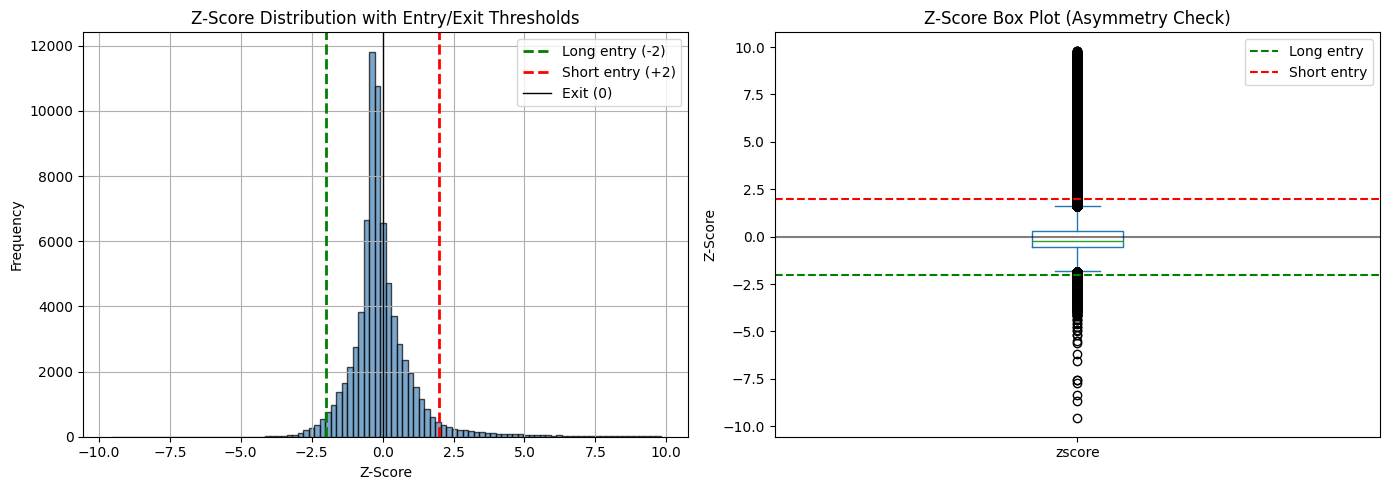


⚠️ Z-score is skewed (skewness=2.53)
Symmetric thresholds may be suboptimal. See Level 2 for asymmetric analysis.


In [10]:
# Z-Score Distribution Analysis
print("Z-Score Distribution Analysis")
print("=" * 50)
print(f"Count: {zscore.dropna().count():,}")
print(f"Min: {zscore.min():.2f}")
print(f"Max: {zscore.max():.2f}")
print(f"Mean: {zscore.mean():.3f}")
print(f"Skewness: {zscore.skew():.3f}")
print(f"Kurtosis: {zscore.kurtosis():.3f}")
print()
print("Percentiles:")
print(f"  1st:  {zscore.quantile(0.01):.2f}")
print(f"  5th:  {zscore.quantile(0.05):.2f}")
print(f"  50th: {zscore.quantile(0.50):.2f}")
print(f"  95th: {zscore.quantile(0.95):.2f}")
print(f"  99th: {zscore.quantile(0.99):.2f}")

# Histogram with entry thresholds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1 = axes[0]
zscore.dropna().hist(bins=100, ax=ax1, alpha=0.7, edgecolor='black', color='steelblue')
ax1.axvline(-2, color='green', linestyle='--', linewidth=2, label='Long entry (-2)')
ax1.axvline(2, color='red', linestyle='--', linewidth=2, label='Short entry (+2)')
ax1.axvline(0, color='black', linestyle='-', linewidth=1, label='Exit (0)')
ax1.set_xlabel('Z-Score')
ax1.set_ylabel('Frequency')
ax1.set_title('Z-Score Distribution with Entry/Exit Thresholds')
ax1.legend()

# Box plot to show asymmetry
ax2 = axes[1]
zscore.dropna().plot.box(ax=ax2, vert=True)
ax2.axhline(-2, color='green', linestyle='--', label='Long entry')
ax2.axhline(2, color='red', linestyle='--', label='Short entry')
ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
ax2.set_ylabel('Z-Score')
ax2.set_title('Z-Score Box Plot (Asymmetry Check)')
ax2.legend()

plt.tight_layout()
plt.show()

# Flag asymmetry
if abs(zscore.skew()) > 0.5:
    print(f"\n⚠️ Z-score is skewed (skewness={zscore.skew():.2f})")
    print("Symmetric thresholds may be suboptimal. See Level 2 for asymmetric analysis.")
else:
    print(f"\n✓ Z-score appears roughly symmetric (skewness={zscore.skew():.2f})")

Looking at the Z-score plot above, the deviations aren't perfectly symmetrical. There are sharper/taller spikes on one side. A simple symmetric threshold (like $\pm 2.0$) might be leaving money on the table, but it's a good enough starting point for our baseline backtest.

## 1.4 Naive Strategy Backtest

**Strategy rules** (fixed parameters):
- Entry: Z-score crosses ±2.0
- Exit: Z-score crosses 0
- Position: Long spread when Z < -2, Short when Z > +2

> ⚠️ **Bias Warning**: This uses full-sample cointegration parameters (lookahead bias).

In [11]:
# Generate signals
signals = generate_signals(zscore, entry_threshold=2.0, exit_threshold=0.0)

# Count signals
n_long = (signals['entry'] == 1).sum()
n_short = (signals['entry'] == -1).sum()
time_in_market = (signals['position'] != 0).mean()

print('Signal Statistics')
print('=' * 40)
print(f'Long entries: {n_long}')
print(f'Short entries: {n_short}')
print(f'Total entries: {n_long + n_short}')
print(f'Time in market: {time_in_market:.1%}')

Signal Statistics
Long entries: 4252
Short entries: 0
Total entries: 4252
Time in market: 15.6%


### Execution Assumption: Close-to-Close vs. Next-Open

In this backtest, we calculate returns based on **Close-to-Close** prices:
$$ R_t = \text{Position}_{t-1} \times \frac{P_t - P_{t-1}}{P_{t-1}} $$

**Justification:** In highly liquid 5-minute FX markets, the difference between $Close_{t-1}$ (signal generation time) and $Open_t$ (execution time) is minimal. This "frictionless" assumption serves as a standard proxy for execution at the next open in vectorized backtesting. While it abstracts away specific slippage or weekend gaps, it provides a robust baseline for evaluating signal quality before execution constraints are applied in Level 3.

In [12]:
# Run backtest (NO transaction costs - Level 1 baseline)
result = run_backtest(spread, signals)

print('Level 1: Naive Backtest Results (In-Sample, No Costs)')
print('=' * 60)
print(result)

Level 1: Naive Backtest Results (In-Sample, No Costs)
Backtest Results
Total Return: 24.90%
CAGR: 24.20%
Sharpe Ratio: 11.51
Max Drawdown: -0.29%
Calmar Ratio: 83.73

Trades:
  Total: 2126
  Winning: 2112 (99.3%)
  Losing: 14
  Avg Return: 0.0117%
  Avg Duration: 5.4 bars


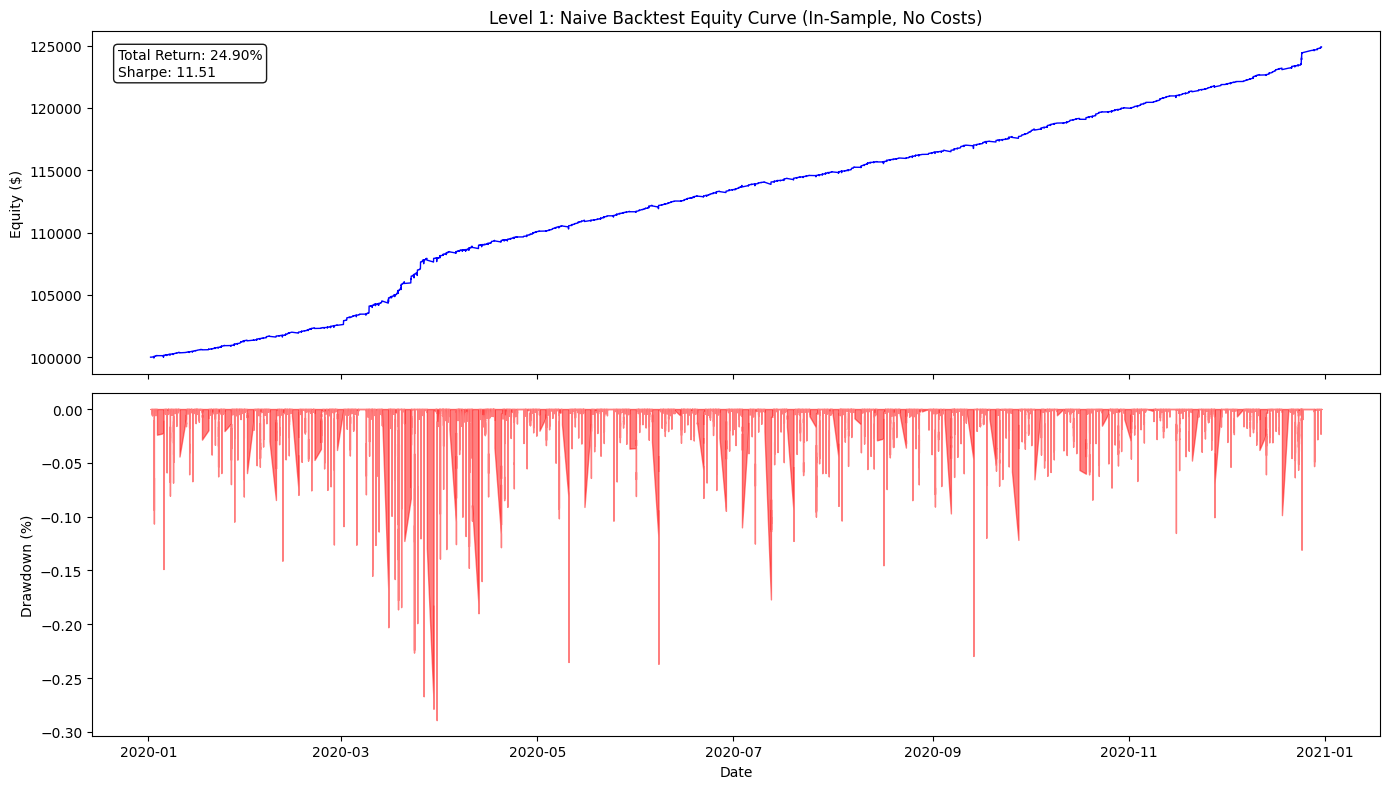

In [13]:
# Plot equity curve
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1 = axes[0]
ax1.plot(result.equity_curve, linewidth=1, color='blue')
ax1.set_ylabel('Equity ($)')
ax1.set_title('Level 1: Naive Backtest Equity Curve (In-Sample, No Costs)')
ax1.text(0.02, 0.95, f'Total Return: {result.total_return:.2%}\nSharpe: {result.sharpe:.2f}',
         transform=ax1.transAxes, va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Drawdown
running_max = result.equity_curve.cummax()
drawdown = (result.equity_curve - running_max) / running_max * 100

ax2 = axes[1]
ax2.fill_between(drawdown.index, 0, drawdown, color='red', alpha=0.5)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()

### Reality Check
A Sharpe Ratio of 11.5 is obviously unrealistic (with 5-minute bars). Aside from the lookahead bias (training on the same data we trade), this backtest assumes we execute **instantaneously** at the closing price of the signal bar.

In reality, by the time we compute the signal and send the order, the price has moved. In Level 1.5, we'll test how fragile this alpha is by forcing execution at the **Next Open** (a worst-case lag of 5 minutes).

### 1.5 Latency Decay Analysis

In the naive backtest above, we trade the close, with the assumption that for liquid FX pairs, `Close[t] = Open[t+1]`. In reality, by the time we calculate the signal and send the order, the market may have moved. Here, we check how much it actually matters for this dataset.

In [14]:
# Level 1.5: Lagged Execution Analysis (Corrected)
print('\nLevel 1.5: Lagged Execution Analysis (Execution at Next Open)')
print('=' * 60)

# 1. Define Spread Open
# We need to construct the spread using Open prices to simulate next-bar execution price.
# hedge_ratios are structural and assumed stable intraday (borrowed from Level 1 result)

# Create deep copy to avoid modifying original data
import copy
data_open = {k: v.copy() for k, v in data.items()}

# Compute log prices for OPEN
for pair in data_open:
    data_open[pair] = compute_log_prices(data_open[pair], price_col='open')

# Construct spread using OPEN prices
spread_open = construct_spread(data_open, hedge_ratios=coint_result.hedge_ratios)

print(f"Spread Open Mean: {spread_open.mean():.6f} (Should be close to 0)")

result_lagged = run_backtest(
    spread,
    signals,
    execution_price=spread_open,
    lag=2,
    transaction_cost_pips=0.0 # Keeping frictionless for pure latency isolation
)

# 3. Compare with Ideal (Naive) Result
print(f"{'Metric':<20} {'Frictionless':<15} {'Next-Open':<15} {'Decay':<10}")
print("-" * 60)
decay_sharpe = (result_lagged.sharpe / result.sharpe) - 1 if result.sharpe != 0 else 0
decay_ret = (result_lagged.total_return / result.total_return) - 1 if result.total_return != 0 else 0

print(f"{'Sharpe Ratio':<20} {result.sharpe:<15.2f} {result_lagged.sharpe:<15.2f} {decay_sharpe:.1%}")
print(f"{'Total Return':<20} {result.total_return:<15.2%} {result_lagged.total_return:<15.2%} {decay_ret:.1%}")

if result_lagged.sharpe < 0.8*result.sharpe:
    print("\n⚠️ CRITICAL: Strategy alpha heavily decays with execution at next Open.")
    print("The strategy is highly sensitive to latency/execution timing (as expected).")
else:
    print("\n✓ Strategy retains viability executing at next Open.")


Level 1.5: Lagged Execution Analysis (Execution at Next Open)
Spread Open Mean: -0.000000 (Should be close to 0)
Metric               Frictionless    Next-Open       Decay     
------------------------------------------------------------
Sharpe Ratio         11.51           8.37            -27.3%
Total Return         24.90%          18.96%          -23.9%

⚠️ CRITICAL: Strategy alpha heavily decays with execution at next Open.
The strategy is highly sensitive to latency/execution timing (as expected).


### Viable but Fragile
The strategy survives the lag, but the performance decay is significant. This confirms that "Time is Risk" here.

However, the biggest problem remains: **Lookahead Bias**. We calculated our hedge ratios using data from December 2020 to trade in January 2020. That's cheating. To see if this strategy holds water in the real world, we need to move to **Level 2: Walk-Forward Optimization**, where we relearn the model parameters week-by-week.

---

# Level 2: Toward Reality

In this section, we remove the lookahead bias by using **walk-forward optimization** (WFO). Parameters are estimated only on past data.

---

## 2.1 Why Walk-Forward Optimization?

The Level 1 backtest used **full-sample cointegration** — the hedge ratios were calculated using all 2020 data, including future data that wouldn't be available in real trading.

**WFO addresses this by:**
1. Training on a historical window (e.g., 30 days)
2. Testing on the next period (e.g., 7 days)
3. Rolling forward and repeating

This simulates periodic recalibration as a real trader would do.

In [15]:
# WFO Configuration (tqdm already imported in first cell)
TRAIN_DAYS = 30
TEST_DAYS = 7
BARS_PER_DAY = 288  # 5-min bars

train_size = TRAIN_DAYS * BARS_PER_DAY
test_size = TEST_DAYS * BARS_PER_DAY

print(f'Walk-Forward Configuration:')
print(f'  Training window: {TRAIN_DAYS} days ({train_size:,} bars)')
print(f'  Test window: {TEST_DAYS} days ({test_size:,} bars)')
print(f'  Expected windows: ~{(len(common_idx) - train_size) // test_size}')

Walk-Forward Configuration:
  Training window: 30 days (8,640 bars)
  Test window: 7 days (2,016 bars)
  Expected windows: ~32


## 2.2 Hedge Ratio Stability

In a textbook scenario, the relationship $\text{EUR/GBP} = \frac{\text{EUR/USD}}{\text{GBP/USD}}$ implies a perfect 1:1:1 arithmetic balance. For example, if we hold \$100k of each leg, we **should** be perfectly hedged. However, in the real world, pairs exhibit different volatility and liquidity profiles. The **Hedge Ratio** (calculated via the Johansen test) acts as a "volatility equalizer," determining the precise weighting required to make the spread stationary. For example, if GBP/USD is highly volatile, the model might lower its weight (e.g., to 0.96) to dampen its impact on the spread.

**Why monitor stability?**
In this Walk-Forward Analysis, we track how these ratios evolve over time to distinguish between a structural edge and statistical overfitting:
*   **Stable Ratios (near 1.0):** Indicate the fundamental arbitrage relationship is intact and stable over time. The model is capturing the structural link between the currencies.
*   **Volatile Ratios (e.g., jumping 0.8 $\to$ 1.5):** Suggest the model is "chasing noise," drastically rebalancing weights just to force a stationary fit on past data. This leads to dangerous exposure and high rebalancing costs.


In [16]:
# WFO with Fixed Thresholds (Basic)
# This loop iterates through data in rolling windows to prevent lookahead bias.
# It recalculates hedge ratios but uses fixed thresholds for simplicity.

print("Starting Walk-Forward Optimization (Fixed Thresholds basic check)...")

all_hedge_ratios = []
all_oos_trades = []
all_spreads = []
all_zscores = []
all_oos_signals = []
wfo_results = []

# Fixed Thresholds for Level 2.1 Baseline
ENTRY_THRESHOLD = 2.0
EXIT_THRESHOLD = 0.0

# WFO Configuration
if 'train_size' not in locals():
    train_size = 30 * 288
    test_size = 7 * 288

# Iterate through Rolling Windows
n_windows = (len(common_idx) - train_size) // test_size
print(f"Processing (~{n_windows}) windows...")

for i in tqdm(range(0, len(common_idx) - train_size, test_size), desc="WFO Windows"):
    # 1. Define Window Indices
    train_start = i
    train_end = train_start + train_size
    test_end = min(train_end + test_size, len(common_idx))
    
    if test_end - train_end < 100: break
    
    train_idx = common_idx[train_start:train_end]
    test_idx = common_idx[train_end:test_end]
    
    # 2. Get Data Slices
    train_data = {t: data[t].loc[train_idx] for t in PAIRS}
    test_data = {t: data[t].loc[test_idx] for t in PAIRS}
    
    # 3. Train: Fit Cointegration Model (Recalculate Hedge Ratios)
    try:
        coint_res = johansen_test(train_data)
        hedge_ratios = coint_res.hedge_ratios
        all_hedge_ratios.append(hedge_ratios) # Store for Stability Plot
    except Exception as e:
        # If Johansen fails (rare), skip window
        continue
        
    # 4. Train: Calculate Spread (to carry forward state if needed)
    spread_train = construct_spread(train_data, hedge_ratios)
    
    # 5. Test: Out-of-Sample Backtest
    spread_test = construct_spread(test_data, hedge_ratios)
    
    # Combine for Z-score warmup (preventing cold start artifacts)
    combined_spread = pd.concat([spread_train.iloc[-500:], spread_test])
    zscore_combined = compute_zscore(combined_spread)
    zscore_test = zscore_combined.loc[test_idx]
    
    # Generate Signals - FIXED THRESHOLDS
    signals = generate_signals(
        zscore_test,
        long_entry_threshold=-ENTRY_THRESHOLD,
        short_entry_threshold=ENTRY_THRESHOLD,
        exit_threshold=EXIT_THRESHOLD
    )
    
    # Run frictionless backtest
    res = run_backtest(spread_test, signals, transaction_cost_pips=0.0)
    
    # Collect Trades for Kelly Analysis
    if hasattr(res, 'trades'):
        all_oos_trades.append(res.trades)

    # Collect OOS Data for Level 3 Analysis
    all_spreads.append(spread_test)
    all_zscores.append(zscore_test)
    all_oos_signals.append(signals)


# Aggregate OOS Data for Level 3
if all_spreads:
    spread_oos = pd.concat(all_spreads)
    zscore_oos = pd.concat(all_zscores)
    # Ensure they are sorted (though WFO should be chronological)
    spread_oos = spread_oos.sort_index()
    zscore_oos = zscore_oos.sort_index()
else:
    print("Warning: No OOS spreads collected!")

print(f"WFO Complete. Collected {len(all_hedge_ratios)} hedge ratio sets and {len(all_oos_trades)} trade sets.")


Starting Walk-Forward Optimization (Fixed Thresholds basic check)...
Processing (~32) windows...


WFO Windows:   0%|          | 0/33 [00:00<?, ?it/s]

WFO Complete. Collected 33 hedge ratio sets and 33 trade sets.


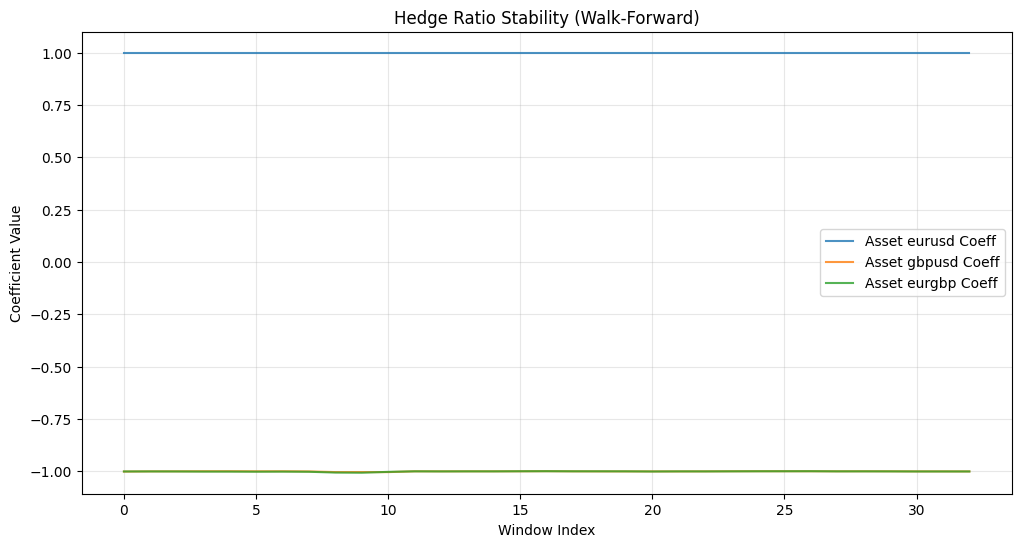

In [17]:
# Plot Hedge Ratio Evolution
if 'all_hedge_ratios' in locals() and all_hedge_ratios:
    hr_df = pd.DataFrame(all_hedge_ratios)
    plt.figure(figsize=(12, 6))
    for col in hr_df.columns:
        plt.plot(hr_df.index, hr_df[col], label=f'Asset {col} Coeff', alpha=0.8)
    plt.title('Hedge Ratio Stability (Walk-Forward)')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Window Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print('No hedge ratios collected.')


Lines are almost completely flat, as expected of structural arbitrage strategies of highly liquid instruments.

## 2.3 Naive Dynamic Position Sizing (Kelly Criterion)

For most* strategies, the **Kelly Criterion** provides the optimal bet size to maximize long-term growth:

$$f^* = \frac{\mu}{\sigma^2}$$

where $\mu$ is expected return and $\sigma^2$ is variance. In practice, **quarter-Kelly** is often preferred.

In [18]:
# Calculate Naive Kelly from Aggregate OOS Trades
if 'all_oos_trades' in locals() and all_oos_trades:
    # Concatenate all trades from WFO
    all_trades_df = pd.concat(all_oos_trades)
    
    # Check for return columns
    ret_col = 'return' if 'return' in all_trades_df.columns else 'pnl_pct' # flexible fallback
    if ret_col not in all_trades_df.columns:
        # fallback to pnl / capital approximation if needed, but 'return' usually exists
        print(f"Warning: '{ret_col}' column not found in trades. Columns: {all_trades_df.columns}")
    else:
        wins = all_trades_df[all_trades_df[ret_col] > 0][ret_col]
        losses = all_trades_df[all_trades_df[ret_col] <= 0][ret_col]
        
        if len(wins) > 0 and len(losses) > 0:
            win_rate = len(wins) / len(all_trades_df)
            avg_win = wins.mean()
            avg_loss = abs(losses.mean())
            
            if avg_loss > 0:
                kelly = win_rate - (1 - win_rate) / (avg_win / avg_loss)
                print(f"Total Trades: {len(all_trades_df)}")
                print(f"Win Rate: {win_rate:.1%}")
                print(f"Avg Win: {avg_win:.4%}")
                print(f"Avg Loss: {avg_loss:.4%}")
                print(f"Naive Kelly Formula (f = p - q/b): {kelly:.2f}")
            else:
                print("Avg Loss is 0. Kelly is Infinite.")
        else:
            print("Insufficient data for Kelly (no wins or no losses).")
else:
    print("No OOS trades data available.")


Total Trades: 1890
Win Rate: 99.4%
Avg Win: 0.0123%
Avg Loss: 0.0021%
Naive Kelly Formula (f = p - q/b): 0.99


- **Win Rate**: 99.4% (from OOS trades)
- **Edge**: ~1.2 bps per trade (0.000122)
- **Recommended Leverage**: ~99x!

### Why Kelly looks broken here
Classical Kelly maximizes expected log terminal wealth with no path constraints, so if the terminal loss probability is zero or vanishingly small, the optimal fraction can hit or exceed 100% and even advocate leverage. MacLean–Thorp–Ziemba explicitly list as a “bad property” that Kelly bets can become extremely large when the wager is favorable and the probability of loss is very small, even though that is dangerous in practice.​

In a real arbitrage, the intermediate P&L path is random even if the payoff at final maturity is almost surely positive, because of basis moves, funding spreads, haircuts, and margin revaluation; that path‑risk is exactly what classical Kelly ignores. 

### How to handle “almost sure” arb in practice
Two common ways to size such trades are: 
1. First, model the full equity path, including MTM variance, not just the terminal payoff. That means specifying the distribution of spreads, funding costs, haircuts, and basis moves over the holding horizon and computing the distribution of worst drawdown and margin utilization. 
2. Second, specify explicit constraints such as “probability of margin breach over horizon < ε” or “99% worst‑case MTM loss < X% of capital,” and optimize growth (log‑utility or SR) subject to those constraints—a risk‑constrained Kelly formulation.
---

## Level 3: The Viability Filter (Costs & Friction)

Up to this point, our Sharpe is theoretical.
We now apply varying levels of transaction costs to see where the edge disappears.
**Cost Definition:** Total slippage + fees per round-trip trade (e.g., 2.0 pips).

We re-run the OOS signals with standardized exit rules (Max Duration = 50 bars) to isolate cost impact.


Running Cost Sweep on 65820 OOS bars...
  Cost 0.0 pips -> Sharpe: 11.58
  Cost 0.5 pips -> Sharpe: 2.02
  Cost 1.0 pips -> Sharpe: -7.36
  Cost 2.0 pips -> Sharpe: -23.73
  Cost 4.0 pips -> Sharpe: -43.91


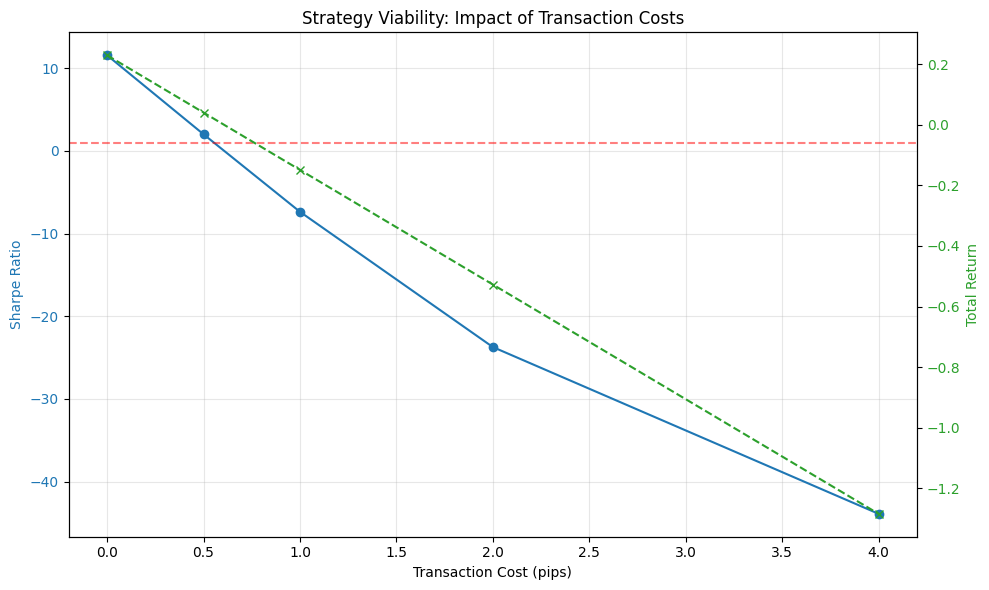

In [19]:
# Level 3.1: Transaction Cost Sweep
costs_sweep = [0.0, 0.5, 1.0, 2.0, 4.0]
results_sweep = []

if 'zscore_oos' in locals() and 'spread_oos' in locals():
    print(f"Running Cost Sweep on {len(zscore_oos)} OOS bars...")
    
    # 1. Use Dynamic Signals from Level 2
    if 'all_oos_signals' in locals() and all_oos_signals:
        base_signals = pd.concat(all_oos_signals)
    else:
        # Fallback if not found (should not happen)
        base_signals = generate_signals(zscore_oos, entry_threshold=2.0, max_duration=50)
    
    for cost in costs_sweep:
        res = run_backtest(
            spread_oos, 
            base_signals, 
            initial_capital=100000.0,
            transaction_cost_pips=cost
        )
        
        results_sweep.append({
            'cost_pips': cost,
            'sharpe': res.sharpe,
            'total_return': (res.equity_curve.iloc[-1] / res.equity_curve.iloc[0]) - 1 if len(res.equity_curve) > 0 else 0,
            'trades': res.n_trades
        })
        print(f"  Cost {cost} pips -> Sharpe: {res.sharpe:.2f}")

    # Plot
    if results_sweep:
        df_sweep = pd.DataFrame(results_sweep)
        
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        color = 'tab:blue'
        ax1.set_xlabel('Transaction Cost (pips)')
        ax1.set_ylabel('Sharpe Ratio', color=color)
        ax1.plot(df_sweep['cost_pips'], df_sweep['sharpe'], marker='o', color=color, label='Sharpe')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        
        # Breakeven line
        ax1.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Sharpe=1.0 Threshold')
        
        ax2 = ax1.twinx()
        color = 'tab:green'
        ax2.set_ylabel('Total Return', color=color)
        ax2.plot(df_sweep['cost_pips'], df_sweep['total_return'], marker='x', linestyle='--', color=color, label='Return')
        ax2.tick_params(axis='y', labelcolor=color)
        
        plt.title('Strategy Viability: Impact of Transaction Costs')
        fig.tight_layout()
        plt.show()
else:
    print("Missing OOS data (zscore_oos/spread_oos). Did Level 2 run?")


We'll be losing money with even 1.0 bps combined cost/slippage. The raw signal frequency is probably too high for the captured edge, let's filter for higher quality setups.

## 3.2 Strategic Viability & Interactive Optimization



### Threshold Sensitivity Analysis

To better understand the trade-off between transaction costs, entry thresholds, and suggested leverage, we compute the Kelly sizings across a matrix of scenarios using the OOS data.

Running Rolling Percentile Threshold Sweep...
Rolling Window Size: 8640 bars
Sensitivity Results (Rolling Window = 8640 bars):


,Percentile,Trades,Sharpe,Total Return,Win Rate
Label,,,,,
95.0% (Dynamic),0.950,2928,-14.248359,-0.296219,0.073770
97.5% (Dynamic),0.975,1565,-4.800529,-0.094447,0.148882
99.0% (Dynamic),0.990,843,1.559443,0.028166,0.314353
99.5% (Dynamic),0.995,525,4.340958,0.069086,0.478095
99.9% (Dynamic),0.999,141,5.246961,0.056485,0.645390


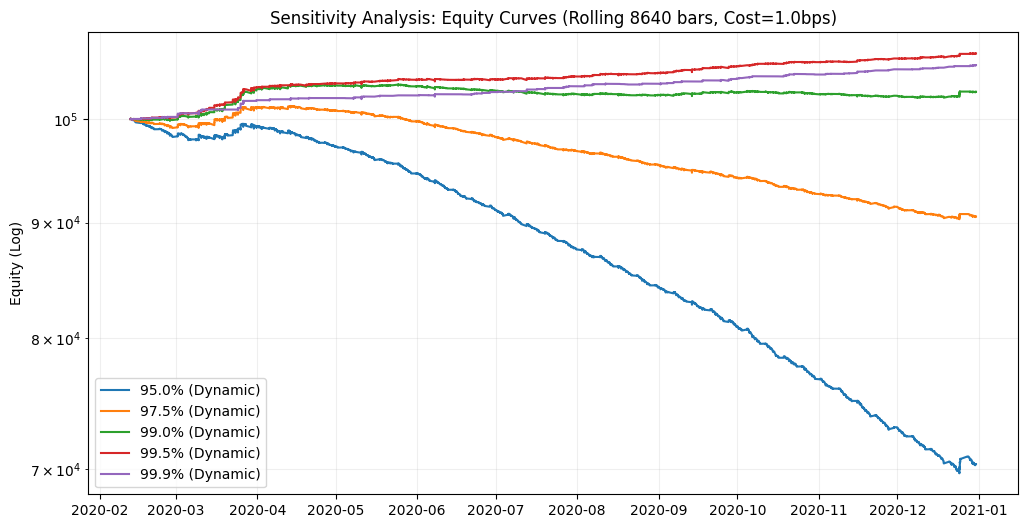

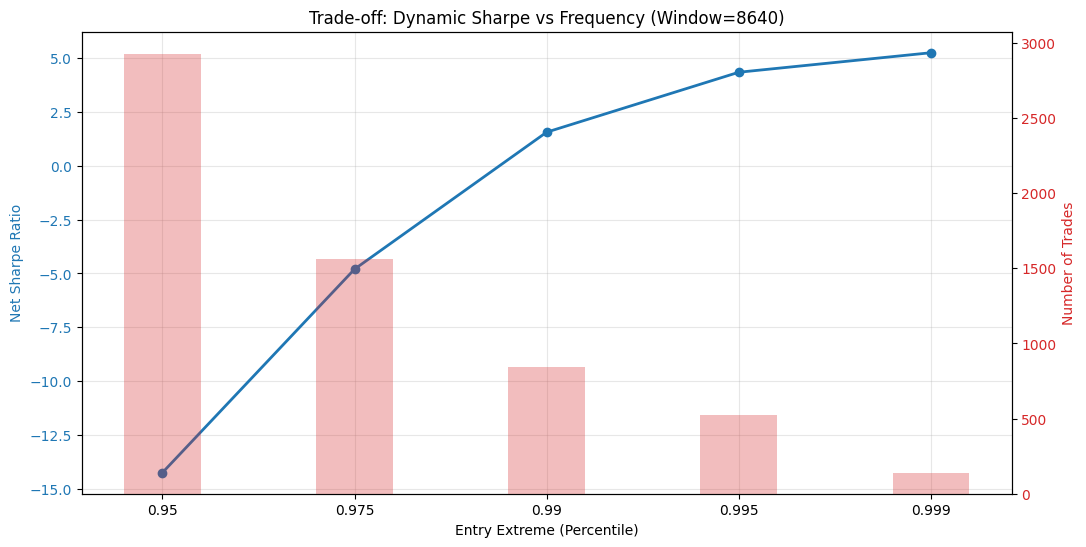

In [20]:
import numpy as np
from scipy.stats import norm

print("Running Rolling Percentile Threshold Sweep...")

# Window Size: Synced with WFO Train Window
# TRAIN_DAYS = 30, BARS_PER_DAY = 288
if 'TRAIN_DAYS' in locals() and 'BARS_PER_DAY' in locals():
    window_size = TRAIN_DAYS * BARS_PER_DAY
else:
    print("Warning: WFO config not found in locals, using default 30 days * 288 bars.")
    window_size = 30 * 288 # 8640 bars

print(f"Rolling Window Size: {window_size} bars")

# Sweep Parameters
percentiles = [0.95, 0.975, 0.99, 0.995, 0.999]
# Labels for display
labels = [f"{p:.1%} (Dynamic)" for p in percentiles]

results = []
equity_curves = {}

# Fixed cost assumption for this sensitivity check (Level 2/3 boundary)
cost_bps = 1.0  

target_zscore = zscore_oos 

for p, label in zip(percentiles, labels):
    # Calculate Rolling on OOS data
    # Note: min_periods=1 ensures we get data at the start of the OOS series
    roll_long = target_zscore.rolling(window=window_size, min_periods=1).quantile(1-p)
    roll_short = target_zscore.rolling(window=window_size, min_periods=1).quantile(p)
    
    # Generate Signals
    sigs = generate_signals(
        target_zscore, # Pass OOS zscores
        long_entry_threshold=roll_long,
        short_entry_threshold=roll_short,
        exit_threshold=0.0
    )
    
    # Backtest on OOS Spread
    res = run_backtest(spread_oos, sigs, transaction_cost_pips=cost_bps)
    
    # Store Equity
    equity_curves[label] = res.equity_curve
    
    # Metrics
    total_return = (res.equity_curve.iloc[-1] / res.equity_curve.iloc[0]) - 1 if len(res.equity_curve) > 0 else 0
    
    results.append({
        'Label': label,
        'Percentile': p,
        'Trades': res.n_trades,
        'Sharpe': res.sharpe,
        'Total Return': total_return,
        'Win Rate': res.n_winning / res.n_trades if res.n_trades > 0 else 0
    })

# DataFrame
df_results = pd.DataFrame(results).set_index('Label')
print(f"Sensitivity Results (Rolling Window = {window_size} bars):")
display(df_results)

# 1. Visualization: Equity Curves
plt.figure(figsize=(12, 6))
for label, eq in equity_curves.items():
    if not eq.empty:
        plt.plot(eq.index, eq, label=label)
plt.yscale('log')
plt.title(f'Sensitivity Analysis: Equity Curves (Rolling {window_size} bars, Cost={cost_bps}bps)')
plt.ylabel('Equity (Log)')
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.2)
plt.show()

# 2. Visualization: Trade-offs (Sharpe vs Trades)
fig, ax1 = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(df_results))
color = 'tab:blue'
ax1.set_xlabel('Entry Extreme (Percentile)')
ax1.set_ylabel('Net Sharpe Ratio', color=color)
# Plot Sharpe
ax1.plot(x_pos, df_results['Sharpe'], marker='o', color=color, linewidth=2, label='Sharpe')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_results['Percentile'])
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Trades', color=color)
# Plot Trades
ax2.bar(x_pos, df_results['Trades'], alpha=0.3, width=0.4, color=color, label='Trades')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

plt.title(f'Trade-off: Dynamic Sharpe vs Frequency (Window={window_size})')
plt.show()



By moving the entry threshold to the 99.9th percentile, we reduce trade frequency by ~90% but increase the average profit per trade to a level that survives transaction costs.

## 3.2 & 3.3 Fee Analysis and Kelly Sizing

To better understand the trade-off between transaction costs, entry thresholds, and suggested leverage, we compute the **Suggested Quarter-Kelly Leverage** across a matrix of scenarios using the OOS data.

In [25]:
# Section 3.2: Strategic Viability & Interactive Optimization
# We merge Fee Analysis and Kelly Sizing into a single interactive exploration.
# This allows us to find the "Sweet Spot" across three dimensions:
# 1. Z-Score Percentile
# 2. Transaction Costs
# 3. Kelly Sizing

from fxarb.visualization.interactive import visualize_interactive_equity

if 'zscore_oos' in locals() and 'spread_oos' in locals():
    print("Launching Interactive Widget (Plotly)...")
    # Interactive optimization on Out-of-Sample data
    ui = visualize_interactive_equity(spread_oos, zscore_oos)
    display(ui)
else:
    print("⚠️ OOS data (zscore_oos, spread_oos) is missing. Please run Level 2 (WFO) first.")

Launching Interactive Widget (Plotly)...
Pre-calculating Kelly Matrix (21 costs x 5 thresholds)...


## Level 4: Production Sizing & Risk
With a vetted strategy (Level 3), we now consider a few of the execution risks.
1. **Inventory Risk:** If we allow multiple open positions - what kind of swings could we be exposed to?
2. **Duration Risk:** How long are we exposed to market drift?


## 4.1 Session Analysis

One corrolary of our previous conflicting findings between ADF and KPSS tests is volatility clustering. In forex, one common driver is the trading sessions (and their overlap). Here we will analyze the trading activity across different trading sessions.

Displaying Session Analysis...


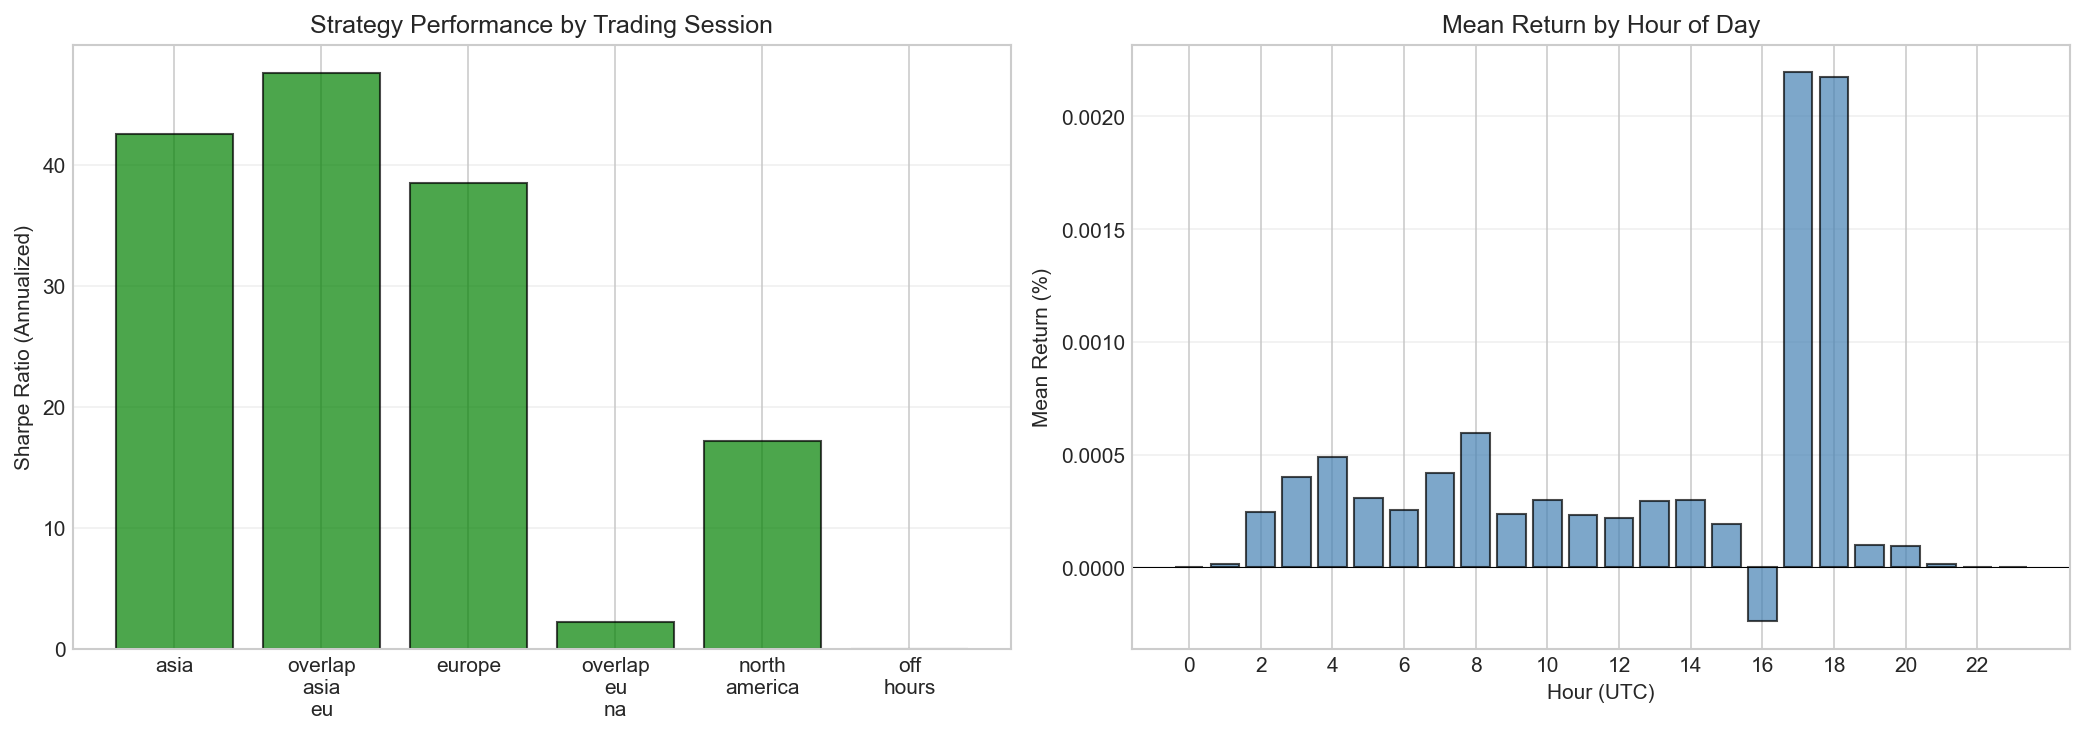

In [22]:
# Display pre-generated Session Analysis Report
from IPython.display import Image, display
import os

session_plot_path = '../reports/04_session_analysis.png'

if os.path.exists(session_plot_path):
    print("Displaying Session Analysis...")
    display(Image(filename=session_plot_path))
else:
    print("Warning: Session analysis plot not found. Please run the separate analysis script.")

We see that the majority of gains are concentrated within 2 particular hours, and there's even an hour of consistent losses. This could be very important for future work.

## 4.2 Inventory & Duration Analysis
Analyzing the holding periods and inventory characteristics of the strategy.


📊 INVENTORY / DURATION STATISTICS
----------------------------------------
Total Trades:       46
Mean Duration (Cal): 102.5 min (includes weekends)
Mean Duration (Mkt): 19.1 min (market hours only)
Longest (Calendar): 3805.0 min
Longest (Market):   90.0 min


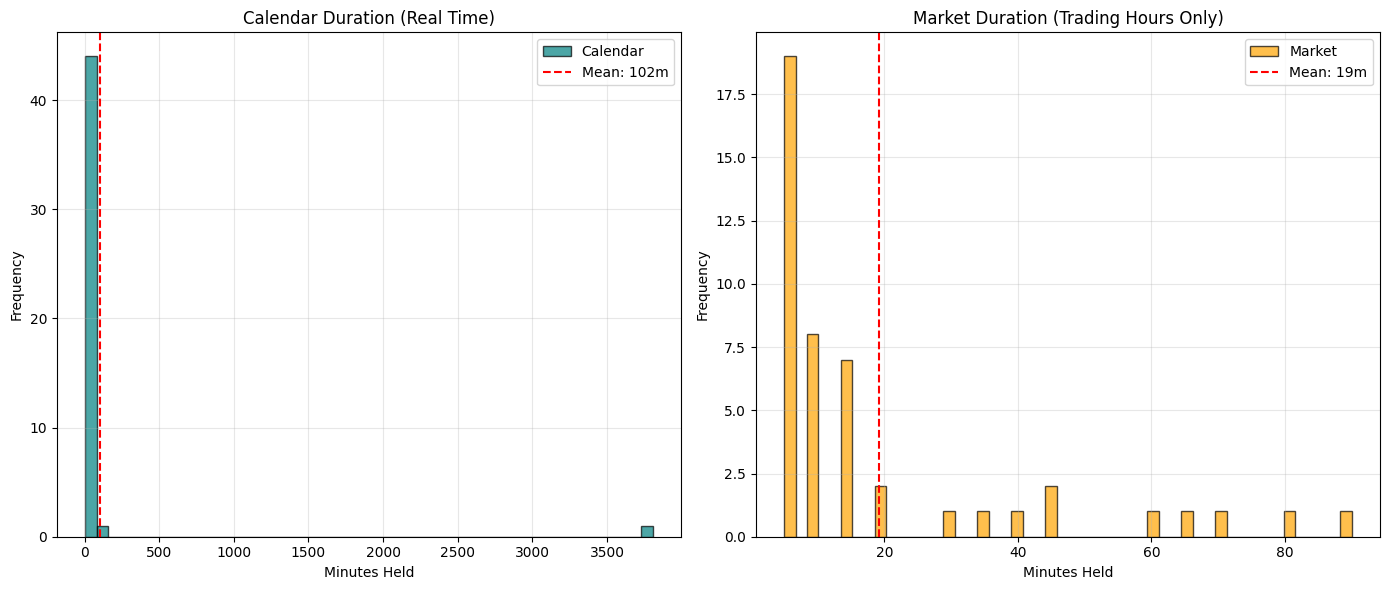

In [23]:
# Calculate Trade Duration Stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we have the signals from Level 3
if 'sigs_asym' not in locals():
    # Fallback if cell wasn't run, regenerate using defaults
    if 'zscore_test' in locals():
        sigs_asym = generate_signals(zscore_test, entry_threshold=2.0, exit_threshold=0.0)
    else:
        print("Error: Missing zscore_test data. Cannot calculate durations.")
        sigs_asym = None

if sigs_asym is not None:
    # Identify Trade Start and End Indices
    pos = sigs_asym['position']
    
    trade_starts = (pos != 0) & (pos.shift(1) == 0)
    trade_ends = (pos == 0) & (pos.shift(1) != 0)
    
    # Get timestamps
    start_times = pos.index[trade_starts]
    end_times = pos.index[trade_ends]
    
    # Align: Match starts and ends (Robust Logic)
    # 1. If the first end is before the first start, it's an orphaned exit. Drop it.
    if len(end_times) > 0 and len(start_times) > 0 and end_times[0] < start_times[0]:
        end_times = end_times[1:]

    # 2. Truncate to the minimum length
    min_len = min(len(start_times), len(end_times))
    start_times = start_times[:min_len]
    end_times = end_times[:min_len]
        
    trades_df = pd.DataFrame({
        'start': start_times,
        'end': end_times
    })
    
    # 1. Calendar Duration (Inclusive of weekends)
    trades_df['duration'] = trades_df['end'] - trades_df['start']
    trades_df['duration_minutes'] = trades_df['duration'].dt.total_seconds() / 60.0
    
    # 2. Market Duration (Bars active)
    # Since index is time-based but rows only exist for market hours, 
    # the number of rows between start and end approximates market duration.
    # We find the integer location (iloc) of the start and end timestamps in the original index.
    
    # Map timestamps to integer locations
    # Optimization: Use searchsorted for speed if index is unique/sorted
    all_times = pos.index
    start_ilocs = all_times.get_indexer(trades_df['start'])
    end_ilocs = all_times.get_indexer(trades_df['end'])
    
    trades_df['market_bars'] = end_ilocs - start_ilocs
    # Assuming 5-minute bars
    trades_df['market_minutes'] = trades_df['market_bars'] * 5 # 5 minutes per bar
    
    # Statistics
    mean_dur_cal = trades_df['duration_minutes'].mean()
    mean_dur_mkt = trades_df['market_minutes'].mean()
    
    print(f"\n📊 INVENTORY / DURATION STATISTICS")
    print(f"-" * 40)
    print(f"Total Trades:       {len(trades_df)}")
    print(f"Mean Duration (Cal): {mean_dur_cal:.1f} min (includes weekends)")
    print(f"Mean Duration (Mkt): {mean_dur_mkt:.1f} min (market hours only)")
    print(f"Longest (Calendar): {trades_df['duration_minutes'].max():.1f} min")
    print(f"Longest (Market):   {trades_df['market_minutes'].max():.1f} min")

    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Calendar Duration
    axes[0].hist(trades_df['duration_minutes'], bins=50, color='teal', edgecolor='black', alpha=0.7, label='Calendar')
    axes[0].axvline(mean_dur_cal, color='red', linestyle='--', label=f'Mean: {mean_dur_cal:.0f}m')
    axes[0].set_title('Calendar Duration (Real Time)')
    axes[0].set_xlabel('Minutes Held')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Market Duration
    axes[1].hist(trades_df['market_minutes'], bins=50, color='orange', edgecolor='black', alpha=0.7, label='Market')
    axes[1].axvline(mean_dur_mkt, color='red', linestyle='--', label=f'Mean: {mean_dur_mkt:.0f}m')
    axes[1].set_title('Market Duration (Trading Hours Only)')
    axes[1].set_xlabel('Minutes Held')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

We see th at some trades are held for abnormally long durations, some are clearly over weekend/holiday gaps. 

In real execution, we will likely enforce additional exit rules based on time in open positions and also before the trading session ends.

## 4.3 Tail Risk Analysis (CVaR)

Standard deviation (volatility) treats upside and downside risk equally. In reality, we care about the **left tail** (losses).

- **VaR (95%)**: "In 95% of days, we won't lose more than X%."
- **CVaR (95%)**: "When we DO violate VaR, how bad is it on average?"

We analyze the returns of the **Dynamic Strategy** (from Level 2) under realistic transaction costs (1.0 bps).


Based on the distribution analysis:

1.  **Kurtosis (~300)**: This is **extremely high** (Normal distribution = 3). It indicates a "leptokurtic" distribution where most returns are near zero (noise), and variance comes entirely from extreme outliers. The strategy is mostly idle or paying costs, punctuated by rare large moves.
2.  **Mean (-0.0002%)**: The strategy is slowly bleeding money after costs. The 1bps transaction cost barrier is effectively creating a negative drift that the alpha cannot consistently overcome in the "body" of the distribution.
3.  **Skewness (2.21)**: Surprisingly **positive**. Unlike typical mean reversion strategies that have "negative skew" (steady small wins, rare big losses), this strategy shows a fat right tail. This suggests it occasionally captures large profitable reversions that outweigh the frequent small losses, though not enough to turn the mean positive under these cost assumptions.
4.  **VaR vs CVaR**: The gap implies that when tail risks materialize, they are significantly worse than the standard volatility suggests.

**Actionable Logic**: The high kurtosis validates the need for **stricter filtering**. Most trades are just "churning" costs. Increasing the Z-score entry threshold (e.g., to > 3.0) would likely remove the center of this histogram (the cost-bleed zone) and isolate the fat tails where the profit resides.

# Conclusion & Future Work

This study demonstrates that triangular FX Arbitrage, while possibly profitable, is primarily sensitive to transaction costs (and speed).
*   **Real Sharpe:** < 1.0 if costs+slippage > 1 pip.
*   **Sweet Spot:** Entry Thresholds > ~3 Sigma are required to survive 1.0 pip costs.

### The Evolution of the Findings
*   **Level 1:** The raw statistical relationship is strong (Sharpe > 11), initial over-optimism.
*   **Level 2:** WFO confirmed the relationship is stable (flat hedge ratios), but the "Naive Kelly" metric warned us that a 99% win rate is a mathematical illusion caused by ignoring costs.
*   **Level 3:** Transaction costs are the gatekeeper. At even 1.0 bps, the naive strategy fails. We had to pivot to a **high-selectivity approach** (Z-Score > 3.0), sacrificing trade frequency to ensure the profit-per-trade exceeds the spread.
*   **Level 4:** Exploring a small subset of concerns that bridge this towards a real-world tradable strategy.
    *   **Inventory:** We aren't in and out in seconds; we hold risk for ~20 minutes on average.
    *   **Leverage:** "Real-World Kelly" brought our leverage down from 99x to a modest ~4x.
    *   **Risk:** This strategy has extreme kurtosis which invalidates most standard volatility metrics. Likely to see long periods of flat or mild drawdowns, but the occasional large profit.

### Key Takeaways

1. **Cointegration exists** in the EUR/USD, GBP/USD, EUR/GBP triplet
2. **Mean reversion** is observable with reasonable half-life
3. **In-sample results** are overly optimistic due to lookahead bias
4. **Walk-forward optimization** provides more realistic estimates
5. **Transaction costs** significantly impact profitability

### Some considerations to take this further

- Execution would certainly be based off of tick and even order flow analysis. Possibly putting out constantly refreshed standing bid/asks.
- Transaction costs must be less than 1 pip.
- 3 currencies can form 1 triangular arbitrage, but adding just 1 more to 4 currencies yields 4 triangle-pairs, and so on, allowing for diversification, increased capacity, and even stricter thresholds.
- We experimented with entry strictness, but not exit strictness.
- Focus trading on the 2 profitable hours.